In [1]:
import pathlib

import hetmatpy.hetmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.metrics
import tqdm

%matplotlib inline

In [2]:
restart_prob = 0.25

In [3]:
data_path = pathlib.Path('../data/edge_predict/')
data_path.mkdir(parents=True, exist_ok=True)

hetmat = hetmatpy.hetmat.HetMat('../data/ppi_hetmat/')

In [4]:
def normalize(matrix):
    # Normalize adjacency matrix
    was_sparse = False
    if scipy.sparse.issparse(matrix):
        was_sparse = True
        matrix = matrix.toarray()
    row_sums = (
        matrix
        .sum(axis=1)
        .reshape(matrix.shape[0], 1)
    )
    row_sums[row_sums == 0] = 1
    normalized = np.divide(matrix, row_sums)
    if was_sparse:
        normalized = scipy.sparse.csc_matrix(normalized)
    return normalized

    
def rwr(normalized_adjacency, start_index, restart_prob, convergence_threshold=1e-6):
    # p(t+1) = (1-r) * W @ p(t) + r * p(0)
    # Setup start position
    p_t = np.zeros((1, normalized_adjacency.shape[0]))
    p_t[0, start_index] = 1
    p_0 = p_t.copy()
    
    # Iterate RWR until converge
    norm_difference = 1
    while norm_difference > convergence_threshold:
        p_t_1 = (1 - restart_prob) * p_t @ normalized_adjacency + restart_prob * p_0
        norm_difference = np.linalg.norm(p_t_1 - p_t, 1)
        p_t = p_t_1
    return p_t


def all_pairs_rwr(adjacency, restart_prob, convergence_threshold=1e-6):
    normalized_adjacency = normalize(adjacency)
    
    rwr_matrix = np.zeros(adjacency.shape)
    
    num_nodes = adjacency.shape[0]
    for seed_index in range(num_nodes):
        rwr_row = rwr(normalized_adjacency, seed_index, restart_prob, 
            convergence_threshold=convergence_threshold)
        rwr_matrix[seed_index, :] = rwr_row
    return rwr_matrix

### 1. Compute edge priors

In [5]:
%%time
sum_perm_edges = None

for name, permat in hetmat.permutations.items():
    source, target, perm_adj = permat.metaedge_to_adjacency_matrix('PpP', dense_threshold=0)
    
    if sum_perm_edges is None:
        sum_perm_edges = perm_adj
    else:
        sum_perm_edges += perm_adj

edge_prior = sum_perm_edges / len(hetmat.permutations)

np.save(data_path.joinpath('prior_edge.npy'), edge_prior)

CPU times: user 22.2 s, sys: 15.5 s, total: 37.7 s
Wall time: 37.7 s


### 2. Compute RWR on the network

In [6]:
%%time

source, target, pruned_matrix = hetmat.metaedge_to_adjacency_matrix('PpP', dense_threshold=1)
ppi_rwr = all_pairs_rwr(pruned_matrix, restart_prob)

np.save(data_path.joinpath('PpP_RWR.npy'), ppi_rwr)

CPU times: user 12 s, sys: 174 ms, total: 12.2 s
Wall time: 12.2 s


### 3. Compute RWR on permuted networks

For speed, use only a subset (100 / 1000) permuted networks

In [7]:
sum_perm_rwr = None
for name, permat in tqdm.tqdm(list(hetmat.permutations.items())[:50]):
    source, target, perm_adj = permat.metaedge_to_adjacency_matrix('PpP', dense_threshold=1)
    rwr_mat = all_pairs_rwr(perm_adj, restart_prob)
    
    if sum_perm_rwr is None:
        sum_perm_rwr = rwr_mat
    else:
        sum_perm_rwr += rwr_mat

mean_rwr = sum_perm_rwr / len(hetmat.permutations)
np.save(data_path.joinpath('prior_RWR.npy'), mean_rwr)

100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


### 4. Flatten features and labels and scale features

In [8]:
original_edge = hetmat.metaedge_to_adjacency_matrix('PiP', dense_threshold=0)[2].flatten()

edge = hetmat.metaedge_to_adjacency_matrix('PpP', dense_threshold=0)[2].flatten()
rwr = ppi_rwr.flatten()
perm_rwr = mean_rwr.flatten()
prior = edge_prior.flatten()

(0.0, 1.0)

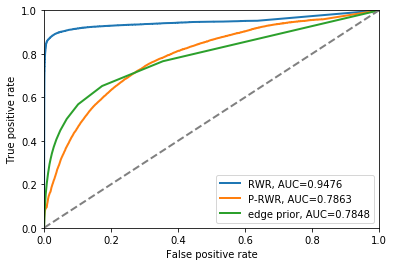

In [9]:
fpr, tpr, thresh = sklearn.metrics.roc_curve(original_edge, rwr)
auc = sklearn.metrics.roc_auc_score(original_edge, rwr)
plt.plot(fpr, tpr, label=f"RWR, AUC={auc :.4f}", lw=2)

fpr, tpr, thresh = sklearn.metrics.roc_curve(original_edge, perm_rwr)
auc = sklearn.metrics.roc_auc_score(original_edge, perm_rwr)
plt.plot(fpr, tpr, label=f"P-RWR, AUC={auc :.4f}", lw=2)

fpr, tpr, thresh = sklearn.metrics.roc_curve(original_edge, prior)
auc = sklearn.metrics.roc_auc_score(original_edge, prior)
plt.plot(fpr, tpr, label=f"edge prior, AUC={auc :.4f}", lw=2)

plt.plot([0,1], [0,1], linestyle='--', color='grey', lw=2)

plt.legend(loc=0)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])